In [22]:
import causal_nf.utils.wandb_local as wandb_local
import causal_nf.config as causal_nf_config
from causal_nf.config import cfg
import causal_nf.utils.training as causal_nf_train
import os
import glob
import argparse
from yacs.config import CfgNode 
import torch
import causal_nf.utils.io as causal_nf_io
import time
import numpy as np
# from causal_nf.preparators.FF_preparator import FFPreparator
from causal_nf.config import cfg
from tqdm import tqdm

In [28]:
ate_folders = ['output_FF_ate1_anFalse', 'output_FF_ate5_anFalse'] 
models = ['model_1', 'model_2', 'model_3']
model_map = {'model_1':'M1', 'model_2':'M2', 'model_3':'M3'}
versions = ['v_0', 'v_1','v_2','v_3','v_4',]#'v_0','v_1','v_2','v_3','v_4',
all_ates = {'output_FF_ate1_anFalse': {'model_1':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},
                              'model_2':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},
                              'model_3':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},},
            'output_FF_ate5_anFalse': {'model_1':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},
                              'model_2':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},
                              'model_3':{'v_0':[],'v_1':[],'v_2':[],'v_3':[],'v_4':[],},} } 

In [29]:
for ate_folder in ate_folders:
    for model in models:
        for version in versions:
            
            base_path = f'./{ate_folder}/{model}/{version}/'

            try:
                directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
            except:    
                print(f"No directories found in {base_path}. Skip. ")
                continue
            
            # Assuming there's only one directory in A/B/C
            if len(directories)==1:
                file_dir = os.path.join(base_path, directories[0])
                print(file_dir)
            elif len(directories)>1:
                print(f"Multiple directories found: {directories} in base path {base_path}")
            
            
            # file_dir = './output_FF_ate1/model_1/v_0/2e684ef6533a11ef991cacde48001122'
            ckpt_file= f"{file_dir}/last.ckpt"
            
            args_list = []
            args =  CfgNode({'config_file': f'{file_dir}/wandb_local/config_local.yaml', 
                             'config_default_file': f'{file_dir}/wandb_local/default_config.yaml', 
                             'project': None, 'wandb_mode': 'disabled', 'wandb_group': None, 
                             'load_model': f'{file_dir}', 'delete_ckpt': False})
            config = causal_nf_config.build_config(
                config_file=args.config_file,
                args_list=args_list,
                config_default_file=args.config_default_file,
            )
            causal_nf_config.assert_cfg_and_config(cfg, config)

            if model=='model_1':
                from causal_nf.preparators.FF_preparator_M1 import FFPreparatorM1 
                preparator = FFPreparatorM1.loader(cfg.dataset)
                index = 4
            if model=='model_2':
                from causal_nf.preparators.FF_preparator_M2 import FFPreparatorM2
                preparator = FFPreparatorM2.loader(cfg.dataset)
                index = 4
            if model=='model_3':
                from causal_nf.preparators.FF_preparator_M3 import FFPreparatorM3
                preparator = FFPreparatorM3.loader(cfg.dataset)
                index = 10
            
            
            preparator.prepare_data()
            
            # IMPORTANT: insert ckpt file otherwise it loads anyway bt something wrong
            model_lightning = causal_nf_train.load_model(cfg=cfg, preparator=preparator, ckpt_file=ckpt_file)
            _ = model_lightning.model.eval()
            
            
            a = 1
            b = 0
            rounds = 5
            
            
            ates = []
            for seed in tqdm(range(rounds)):
                torch.random.manual_seed(seed + 1)
                ate = model_lightning.model.compute_ate(
                    index,
                    a=a,
                    b=b,
                    num_samples=10000,
                    scaler=preparator.scaler_transform,
                )
                ates.append(ate[-1])
            ates = np.array(ates)
            all_ates[ate_folder][model][version] = ates
            
            ate_mean = ates.mean()
            ate_stddev = ates.std()
            print(f"Folder {ate_folder} {model} {version}: Mean ATE over {rounds} rounds = ", ate_mean)
            print(f"Folder {ate_folder} {model} {version}: Stddev ATE over {rounds} rounds = ", ate_stddev)
            

./output_FF_ate1_anFalse/model_1/v_0/1d473d188f2a11ef902cacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_FF_ate1_anFalse/model_1/v_0/1d473d188f2a11ef902cacde48001122/last.ckpt
scaler_transform StandardTransform(shift=tensor([2.7091, 2.7169, 2.7340, 2.7486, 0.9532, 1.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


Folder output_FF_ate1_anFalse model_1 v_0: Mean ATE over 5 rounds =  0.73728263
Folder output_FF_ate1_anFalse model_1 v_0: Stddev ATE over 5 rounds =  0.009643097
./output_FF_ate1_anFalse/model_1/v_1/20a3c4bc8f2b11efbee2acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


Folder output_FF_ate1_anFalse model_1 v_1: Mean ATE over 5 rounds =  0.684651
Folder output_FF_ate1_anFalse model_1 v_1: Stddev ATE over 5 rounds =  0.009066355
./output_FF_ate1_anFalse/model_1/v_2/3cd449268f2c11ef9223acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


Folder output_FF_ate1_anFalse model_1 v_2: Mean ATE over 5 rounds =  0.75290954
Folder output_FF_ate1_anFalse model_1 v_2: Stddev ATE over 5 rounds =  0.009456693
./output_FF_ate1_anFalse/model_1/v_3/8382e5708f2d11efb985acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


Folder output_FF_ate1_anFalse model_1 v_3: Mean ATE over 5 rounds =  0.7520362
Folder output_FF_ate1_anFalse model_1 v_3: Stddev ATE over 5 rounds =  0.008547906
./output_FF_ate1_anFalse/model_1/v_4/d022be728f2e11efb8bcacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


Folder output_FF_ate1_anFalse model_1 v_4: Mean ATE over 5 rounds =  0.7356707
Folder output_FF_ate1_anFalse model_1 v_4: Stddev ATE over 5 rounds =  0.009955804
./output_FF_ate1_anFalse/model_2/v_0/285b356e8f3011efa701acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


Folder output_FF_ate1_anFalse model_2 v_0: Mean ATE over 5 rounds =  1.019069
Folder output_FF_ate1_anFalse model_2 v_0: Stddev ATE over 5 rounds =  0.010042261
./output_FF_ate1_anFalse/model_2/v_1/539bf1908f3111efbcd5acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


Folder output_FF_ate1_anFalse model_2 v_1: Mean ATE over 5 rounds =  0.95031136
Folder output_FF_ate1_anFalse model_2 v_1: Stddev ATE over 5 rounds =  0.009669472
./output_FF_ate1_anFalse/model_2/v_2/916f8a768f3211ef96d9acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


Folder output_FF_ate1_anFalse model_2 v_2: Mean ATE over 5 rounds =  1.1286724
Folder output_FF_ate1_anFalse model_2 v_2: Stddev ATE over 5 rounds =  0.009441156
./output_FF_ate1_anFalse/model_2/v_3/a96b82c88f3311efbebaacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


Folder output_FF_ate1_anFalse model_2 v_3: Mean ATE over 5 rounds =  1.0716747
Folder output_FF_ate1_anFalse model_2 v_3: Stddev ATE over 5 rounds =  0.010324753
./output_FF_ate1_anFalse/model_2/v_4/c7f8f2ba8f3411ef97c9acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


Folder output_FF_ate1_anFalse model_2 v_4: Mean ATE over 5 rounds =  0.884988
Folder output_FF_ate1_anFalse model_2 v_4: Stddev ATE over 5 rounds =  0.010944561
./output_FF_ate1_anFalse/model_3/v_0/14d437f48ccc11efa0f1acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFight

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


Folder output_FF_ate1_anFalse model_3 v_0: Mean ATE over 5 rounds =  0.78236663
Folder output_FF_ate1_anFalse model_3 v_0: Stddev ATE over 5 rounds =  0.012475636
./output_FF_ate1_anFalse/model_3/v_1/89a5068e8ccd11efaffeacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFig

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Folder output_FF_ate1_anFalse model_3 v_1: Mean ATE over 5 rounds =  0.9481517
Folder output_FF_ate1_anFalse model_3 v_1: Stddev ATE over 5 rounds =  0.013156179
./output_FF_ate1_anFalse/model_3/v_2/2d66d4148cd311efadeaacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFigh

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


Folder output_FF_ate1_anFalse model_3 v_2: Mean ATE over 5 rounds =  0.9757414
Folder output_FF_ate1_anFalse model_3 v_2: Stddev ATE over 5 rounds =  0.011912286
./output_FF_ate1_anFalse/model_3/v_3/ce6ab9108cd411ef8a23acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFigh

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


Folder output_FF_ate1_anFalse model_3 v_3: Mean ATE over 5 rounds =  0.82738894
Folder output_FF_ate1_anFalse model_3 v_3: Stddev ATE over 5 rounds =  0.013001755
./output_FF_ate1_anFalse/model_3/v_4/7d99ab8e8cd611efbdfbacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFig

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Folder output_FF_ate1_anFalse model_3 v_4: Mean ATE over 5 rounds =  0.8339732
Folder output_FF_ate1_anFalse model_3 v_4: Stddev ATE over 5 rounds =  0.012134518
./output_FF_ate5_anFalse/model_1/v_0/ee1d2d8e8f3511efac85acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


Folder output_FF_ate5_anFalse model_1 v_0: Mean ATE over 5 rounds =  4.084401
Folder output_FF_ate5_anFalse model_1 v_0: Stddev ATE over 5 rounds =  0.013022638
./output_FF_ate5_anFalse/model_1/v_1/1f08fcb08f3711efa3bbacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


Folder output_FF_ate5_anFalse model_1 v_1: Mean ATE over 5 rounds =  4.1924353
Folder output_FF_ate5_anFalse model_1 v_1: Stddev ATE over 5 rounds =  0.0112803485
./output_FF_ate5_anFalse/model_1/v_2/58386a248f3811ef9fe9acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


Folder output_FF_ate5_anFalse model_1 v_2: Mean ATE over 5 rounds =  4.388764
Folder output_FF_ate5_anFalse model_1 v_2: Stddev ATE over 5 rounds =  0.012271303
./output_FF_ate5_anFalse/model_1/v_3/3f07f6c28f3911efb898acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


Folder output_FF_ate5_anFalse model_1 v_3: Mean ATE over 5 rounds =  4.222287
Folder output_FF_ate5_anFalse model_1 v_3: Stddev ATE over 5 rounds =  0.011889709
./output_FF_ate5_anFalse/model_1/v_4/f9891fee8f3911ef98f7acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


Folder output_FF_ate5_anFalse model_1 v_4: Mean ATE over 5 rounds =  4.2399726
Folder output_FF_ate5_anFalse model_1 v_4: Stddev ATE over 5 rounds =  0.01154777
./output_FF_ate5_anFalse/model_2/v_0/c0c4b17c8f3a11ef8834acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


Folder output_FF_ate5_anFalse model_2 v_0: Mean ATE over 5 rounds =  4.6950774
Folder output_FF_ate5_anFalse model_2 v_0: Stddev ATE over 5 rounds =  0.010693284
./output_FF_ate5_anFalse/model_2/v_1/8d7421d08f3b11efb34aacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Folder output_FF_ate5_anFalse model_2 v_1: Mean ATE over 5 rounds =  4.940567
Folder output_FF_ate5_anFalse model_2 v_1: Stddev ATE over 5 rounds =  0.008893447
./output_FF_ate5_anFalse/model_2/v_2/545aac6a8f3c11ef831cacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Folder output_FF_ate5_anFalse model_2 v_2: Mean ATE over 5 rounds =  5.176228
Folder output_FF_ate5_anFalse model_2 v_2: Stddev ATE over 5 rounds =  0.008800622
./output_FF_ate5_anFalse/model_2/v_3/22fabd8a8f3d11efa843acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_F

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


Folder output_FF_ate5_anFalse model_2 v_3: Mean ATE over 5 rounds =  5.3366995
Folder output_FF_ate5_anFalse model_2 v_3: Stddev ATE over 5 rounds =  0.009885517
./output_FF_ate5_anFalse/model_2/v_4/ef4c289c8f3d11efb489acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=6, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=138, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([6]), scale: torch.Size([6]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFightning'> from ./output_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Folder output_FF_ate5_anFalse model_2 v_4: Mean ATE over 5 rounds =  5.010135
Folder output_FF_ate5_anFalse model_2 v_4: Stddev ATE over 5 rounds =  0.010306808
./output_FF_ate5_anFalse/model_3/v_0/fc8655448cce11efb89facde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFight

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.84s/it]


Folder output_FF_ate5_anFalse model_3 v_0: Mean ATE over 5 rounds =  4.6465425
Folder output_FF_ate5_anFalse model_3 v_0: Stddev ATE over 5 rounds =  0.011909872
./output_FF_ate5_anFalse/model_3/v_1/5e2b35f28cd011efa8f0acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFigh

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]


Folder output_FF_ate5_anFalse model_3 v_1: Mean ATE over 5 rounds =  4.900303
Folder output_FF_ate5_anFalse model_3 v_1: Stddev ATE over 5 rounds =  0.012774208
./output_FF_ate5_anFalse/model_3/v_2/176fcd008cd811ef991aacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFight

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.74s/it]


Folder output_FF_ate5_anFalse model_3 v_2: Mean ATE over 5 rounds =  4.8931274
Folder output_FF_ate5_anFalse model_3 v_2: Stddev ATE over 5 rounds =  0.013791771
./output_FF_ate5_anFalse/model_3/v_3/9d61122e8cd911efaaeeacde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFigh

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Folder output_FF_ate5_anFalse model_3 v_3: Mean ATE over 5 rounds =  4.549229
Folder output_FF_ate5_anFalse model_3 v_3: Stddev ATE over 5 rounds =  0.014754674
./output_FF_ate5_anFalse/model_3/v_4/43d7da4c8cdb11ef9a40acde48001122

Preparing data...

Preparing data...

Preparing data...
NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, ..., 7, 8, 9, 10, 11]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=12, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ELU(alpha=1.0)
        (6): MaskedLinear(in_features=32, out_features=276, bias=True)
      )
    )
  )
  (base): DiagNormal(loc: torch.Size([12]), scale: torch.Size([12]))
)
[INFO] Loading <class 'causal_nf.models.causal_nf.CausalNFight

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]

Folder output_FF_ate5_anFalse model_3 v_4: Mean ATE over 5 rounds =  4.6792707
Folder output_FF_ate5_anFalse model_3 v_4: Stddev ATE over 5 rounds =  0.013229644


In [32]:
all_ates_stats = {'output_FF_ate1_anFalse': {'model_1':{'mean':[], 'std':[]}, 'model_2':{'mean':[], 'std':[]}, 'model_3':{'mean':[], 'std':[]}, },
                 'output_FF_ate5_anFalse': {'model_1':{'mean':[], 'std':[]}, 'model_2':{'mean':[], 'std':[]}, 'model_3':{'mean':[], 'std':[]}, } } 


In [33]:
for ate_folder in ate_folders:
    for model in models:
        ates_model = []
        for version in versions:
            ates_v = all_ates[ate_folder][model][version]
            ates_model += list(ates_v)
        print(ates_model)
        all_ates_stats[ate_folder][model]['mean'] = np.array(ates_model).mean()
        all_ates_stats[ate_folder][model]['std'] = np.array(ates_model).std()
        
        

[0.74170506, 0.72403955, 0.7474501, 0.74571204, 0.7275063, 0.687008, 0.67304075, 0.6920202, 0.69595075, 0.6752355, 0.7575021, 0.7394508, 0.7609292, 0.76282597, 0.7438395, 0.75292134, 0.74003637, 0.7587135, 0.7633687, 0.74514115, 0.73833287, 0.7199769, 0.744738, 0.7463745, 0.7289312]
[1.0217237, 1.001218, 1.0315216, 1.0173025, 1.0235791, 0.9532697, 0.93301153, 0.9601879, 0.94744754, 0.95764005, 1.1312631, 1.1124315, 1.1410182, 1.1260133, 1.1326361, 1.0754958, 1.0533203, 1.0844492, 1.0696572, 1.0754509, 0.8867687, 0.8659631, 0.8978963, 0.8817812, 0.8925307]
[0.78446054, 0.7598336, 0.78506064, 0.7983589, 0.7841197, 0.95228267, 0.9230776, 0.95219433, 0.9621017, 0.9511019, 0.97803104, 0.9535986, 0.97753763, 0.9896543, 0.97988534, 0.8294792, 0.80320954, 0.8300955, 0.8426051, 0.83155525, 0.8377652, 0.81177163, 0.8351793, 0.84888005, 0.83626986]
[4.095886, 4.069171, 4.0938663, 4.095291, 4.067791, 4.1992354, 4.1772623, 4.1998177, 4.205276, 4.180587, 4.397782, 4.37084, 4.3951674, 4.402388, 4.377

In [34]:
#output_FF_anFalse
all_ates_stats

{'output_FF_ate1_anFalse': {'model_1': {'mean': 0.7325101, 'std': 0.02667382},
  'model_2': {'mean': 1.010943, 'std': 0.08679322},
  'model_3': {'mean': 0.8735243, 'std': 0.07590384}},
 'output_FF_ate5_anFalse': {'model_1': {'mean': 4.225572, 'std': 0.09858912},
  'model_2': {'mean': 5.031741, 'std': 0.21747321},
  'model_3': {'mean': 4.7336946, 'std': 0.14046367}}}

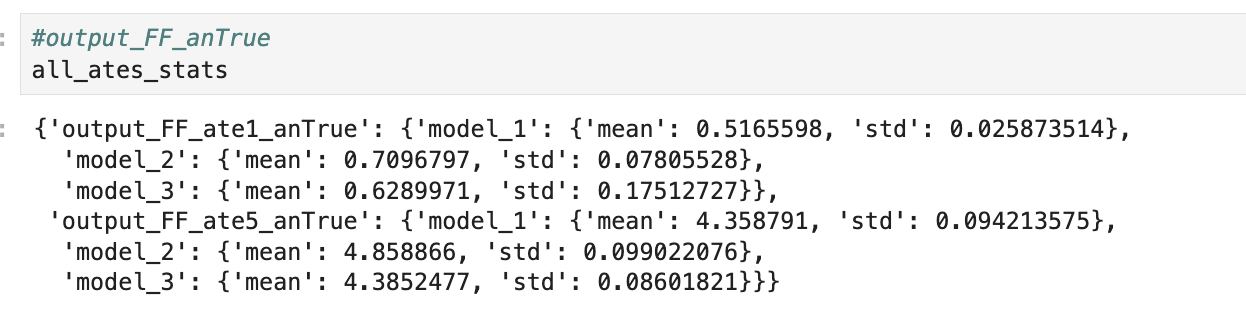